In [54]:
### Add lines to import modules as needed
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from keras import Sequential, Input, layers, Model
from keras.datasets import cifar10
from keras.optimizers import Adam, SGD
from keras.losses import categorical_crossentropy
from keras.utils import np_utils, plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import load_img
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as pp
import os
import cv2
from PIL import Image
import fiftyone
# Don't worry about this, for some reason the SSL certificate isn't verifying for the Cifar10 dataset and this is the workaround
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [71]:
#define model
def mobilenet_v1():
    # Mobilenet parameters
    input_shape = [96,96,1] # resized to 96x96 per EEMBC requirement
    num_classes = 2 # person and non-person
    num_filters = 8 # normally 32, but running with alpha=.25 per EEMBC requirement

    inputs = Input(shape=input_shape)
    x = inputs # Keras model uses ZeroPadding2D()

    # 1st layer, pure conv
    # Keras 2.2 model has padding='valid' and disables bias
    x = layers.Conv2D(num_filters,
                  kernel_size=3,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x) # Keras uses ReLU6 instead of pure ReLU

    # 2nd layer, depthwise separable conv
    # Filter size is always doubled before the pointwise conv
    # Keras uses ZeroPadding2D() and padding='valid'
    x = layers.DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    num_filters = 2*num_filters
    x = layers.Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # 3rd layer, depthwise separable conv
    x = layers.DepthwiseConv2D(kernel_size=3,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    num_filters = 2*num_filters
    x = layers.Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # 4th layer, depthwise separable conv
    x = layers.DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # 5th layer, depthwise separable conv
    x = layers.DepthwiseConv2D(kernel_size=3,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    num_filters = 2*num_filters
    x = layers.Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # 6th layer, depthwise separable conv
    x = layers.DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # 7th layer, depthwise separable conv
    x = layers.DepthwiseConv2D(kernel_size=3,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    num_filters = 2*num_filters
    x = layers.Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # 8th-12th layers, identical depthwise separable convs
    # 8th
    x = layers.DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # 9th
    x = layers.DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # 10th
    x = layers.DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # 11th
    x = layers.DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # 12th
    x = layers.DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # 13th layer, depthwise separable conv
    x = layers.DepthwiseConv2D(kernel_size=3,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    num_filters = 2*num_filters
    x = layers.Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # 14th layer, depthwise separable conv
    x = layers.DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Average pooling, max polling may be used also
    # Keras employs GlobalAveragePooling2D 
    x = layers.AveragePooling2D(pool_size=x.shape[1:3])(x)
    #x = layers.MaxPooling2D(pool_size=x.shape[1:3])(x)

    # Keras inserts Dropout() and a pointwise Conv2D() here
    # We are staying with the paper base structure

    # Flatten, FC layer and classify
    x = layers.Flatten()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [72]:
#(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

img_size_x = 96
img_size_y = 96
batch_size = 16
data_dir = "C:\\Users\\lucas\\Documents\\GitHub\\Plasma_Dragon_Charged_Up_Code\\Machine_Learning\\training\\Plasma_Dragon_Cube_dataset\\"

train_ds = keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_size_x, img_size_y),
  batch_size=batch_size,
  color_mode='grayscale',
  label_mode='categorical')
val_ds = keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_size_x, img_size_y),
  batch_size=batch_size,
  color_mode='grayscale',
  label_mode='categorical')
normalization_layer = tf.keras.layers.Rescaling(1./255)
num_classes = 2
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
#train_images = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in train_images])
#test_images = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in test_images])

#ti2 = train_images[44:47]
#tl2 = train_labels[44:47]

#train_images = train_images[0:10]
#train_images[7:10] = ti2
#train_labels = train_labels[0:10]
#train_labels[7:10] = tl2
#test_images = test_images[0:5]
#test_labels = test_labels[0:5]

#os.mkdir("train_images")
#os.chdir("train_images")

#for i in range(0,len(train_images)):
    #image = Image.fromarray(train_images[i])
    #filename = "image_"+str(i)+".jpg"
    #image.save(filename)

"""train_images = train_images / 255.0
test_images  = test_images  / 255.0
for i in range(0,len(train_labels)):
    #print(train_labels[i])
    if train_labels[i] != 1:
        train_labels[i] = 0
train_labels = np_utils.to_categorical(train_labels)
for i in range(0,len(test_labels)):
    if test_labels[i] != 1:
        test_labels[i] = 0
test_labels = np_utils.to_categorical(test_labels)

train_images"""
mc = ModelCheckpoint(
    filepath = 'C:/Users/lucas/Documents/GitHub/mliot-hw2-lucastherrien/best_model.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
es = EarlyStopping(monitor='loss', patience=3)

Found 68 files belonging to 2 classes.
Using 55 files for training.
Found 68 files belonging to 2 classes.
Using 13 files for validation.


In [73]:
for data_batch, label_batch in train_ds:
    print('Data batch shape:', data_batch.shape)
    print('Label batch shape:', label_batch.shape)
    print(label_batch.numpy())
    break  # Only print the first batch

Data batch shape: (16, 96, 96, 1)
Label batch shape: (16, 2)
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [80]:
model = mobilenet_v1()
model.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 96, 96, 1)]       0         
                                                                 
 conv2d_262 (Conv2D)         (None, 48, 48, 8)         80        
                                                                 
 batch_normalization_504 (Ba  (None, 48, 48, 8)        32        
 tchNormalization)                                               
                                                                 
 activation_504 (Activation)  (None, 48, 48, 8)        0         
                                                                 
 depthwise_conv2d_242 (Depth  (None, 48, 48, 8)        80        
 wiseConv2D)                                                     
                                                                 
 batch_normalization_505 (Ba  (None, 48, 48, 8)        32 

In [83]:
model.compile(optimizer=SGD(learning_rate=0.0005),loss=categorical_crossentropy,metrics=['accuracy'])
history = model.fit(train_ds, validation_data=val_ds, batch_size=16, epochs=100,callbacks=[mc])

Epoch 1/100
4/4 [==============================] - 6s 446ms/step - loss: 0.7413 - accuracy: 0.8182 - val_loss: 1.0158 - val_accuracy: 0.6154
Epoch 2/100
4/4 [==============================] - 0s 88ms/step - loss: 0.7457 - accuracy: 0.8909 - val_loss: 1.0591 - val_accuracy: 0.4615
Epoch 3/100
4/4 [==============================] - 0s 78ms/step - loss: 0.7620 - accuracy: 0.8545 - val_loss: 0.7883 - val_accuracy: 0.7692
Epoch 4/100
4/4 [==============================] - 0s 71ms/step - loss: 0.8218 - accuracy: 0.7818 - val_loss: 0.9300 - val_accuracy: 0.5385
Epoch 5/100
4/4 [==============================] - 0s 73ms/step - loss: 0.6963 - accuracy: 0.9455 - val_loss: 0.9692 - val_accuracy: 0.6154
Epoch 6/100
4/4 [==============================] - 0s 77ms/step - loss: 0.7860 - accuracy: 0.8545 - val_loss: 0.7989 - val_accuracy: 0.9231
Epoch 7/100
4/4 [==============================] - 0s 84ms/step - loss: 0.6965 - accuracy: 0.9455 - val_loss: 0.9222 - val_accuracy: 0.6923
Epoch 8/100
4/4 [==

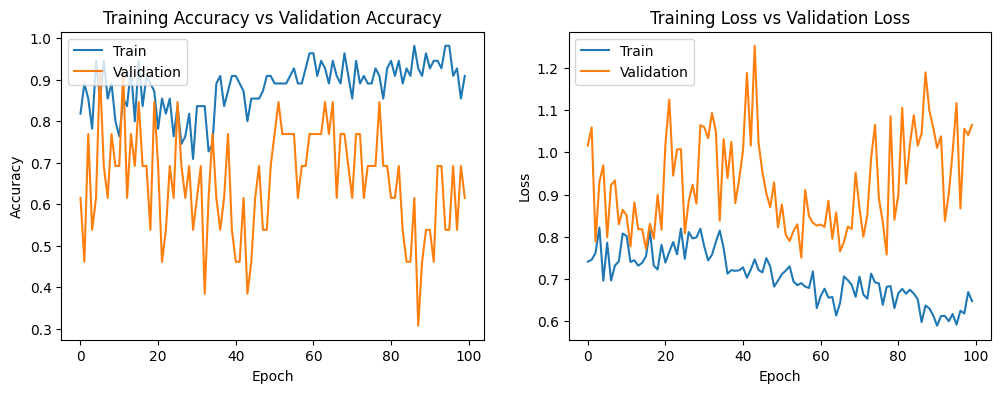

In [84]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')


In [24]:
model = keras.models.load_model('best_model.h5')